## Analysis of the Government of Canada's Budget Allocation and Spending Patterns**

This project analyzes the **Government of Canada's** budget data over multiple fiscal years (2011-2024) to gain insights into how federal departments allocate and utilize their funding. The analysis uses **Big Data** techniques to identify trends, inefficiencies, and forecasting patterns, with a focus on budget allocation, actual expenditures, and future predictions.

Key steps include:
1. **Trend Analysis:** A detailed comparison of **budget allocation** and **expenditures** to analyze the fiscal trajectory of government spending over time.
2. **K-Means Clustering:** Grouping departments based on their financial behavior to identify patterns in spending, with the goal of understanding which departments exhibit similar budgetary characteristics.
3. **Expenditure Forecasting:** Using **linear regression models** to predict future expenditures, with a focus on determining how past spending influences future budget allocations.
4. **Visualizations:** Visualizing data trends using various charts like line charts, bar charts, heatmaps to gain better insights regarding government financial performance.

The goal of this project is to provide actionable insights into budget efficiency, predict future financial behavior, and create visual representations that can assist policymakers in planning and decision-making.

With the combination of **data analysis**, **forecasting**, and **visualization**, this project provides a comprehensive approach to understanding and predicting government budget trends.

### 1. Importing Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import urllib.request
import json
from scipy.stats import zscore
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [4]:
print("1. Checking system specifications...")
print(f"Total RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print(f"Available RAM: {round(psutil.virtual_memory().available / (1024**3), 2)} GB")
print(f"CPU Usage: {psutil.cpu_percent()}%")

1. Checking system specifications...
Total RAM: 8.0 GB
Available RAM: 1.83 GB
CPU Usage: 41.1%


### 2. Loading dataset
This project explores the dataset PAC_AEbyVote.csv, which contains detailed financial records from the Public Accounts of Canada. It includes information on:

- Government departments and organizations
- Budget authorities granted
- Actual expenditures
- Classification into voted or statutory spending

**Data Source:** Government of Canada Open Data  

In [6]:
df = pd.read_csv("PAC_AEbyVote.csv") 
print("Dataset loaded successfully! Shape:", df.shape)

print("First few rows of the dataset:")
print(df.head())

Dataset loaded successfully! Shape: (7692, 7)
First few rows of the dataset:
        fy_ef  org_id                                 org_name  \
0  FY 2011-12     1.0  Department of Agriculture and Agri-Food   
1  FY 2011-12     1.0  Department of Agriculture and Agri-Food   
2  FY 2011-12     1.0  Department of Agriculture and Agri-Food   
3  FY 2011-12     1.0  Department of Agriculture and Agri-Food   
4  FY 2011-12     1.0  Department of Agriculture and Agri-Food   

  voted_or_statutory                                   description  \
0                  1                             Operating/Program   
1                 10                        Grants & Contributions   
2                  5                                       Capital   
3                  S  Canadian Cattlemen's Association Legacy Fund   
4                  S    Canadian Pari-Mutuel Agency Revolving Fund   

   authorities  expenditures  
0  756690489.0  7.049413e+08  
1  459143202.0  3.599418e+08  
2   34150756

### 3. Exploring the Data

In [8]:
print("Checking for missing values...")
print(df.isnull().sum())

print("Checking for duplicate records...")
print(f"Duplicate rows found: {df.duplicated().sum()}")
if df.duplicated().sum()>0:
    print("Duplicates exists")
    df.drop_duplicates()

Checking for missing values...
fy_ef                   0
org_id                  1
org_name                0
voted_or_statutory      0
description             0
authorities            35
expenditures          228
dtype: int64
Checking for duplicate records...
Duplicate rows found: 0


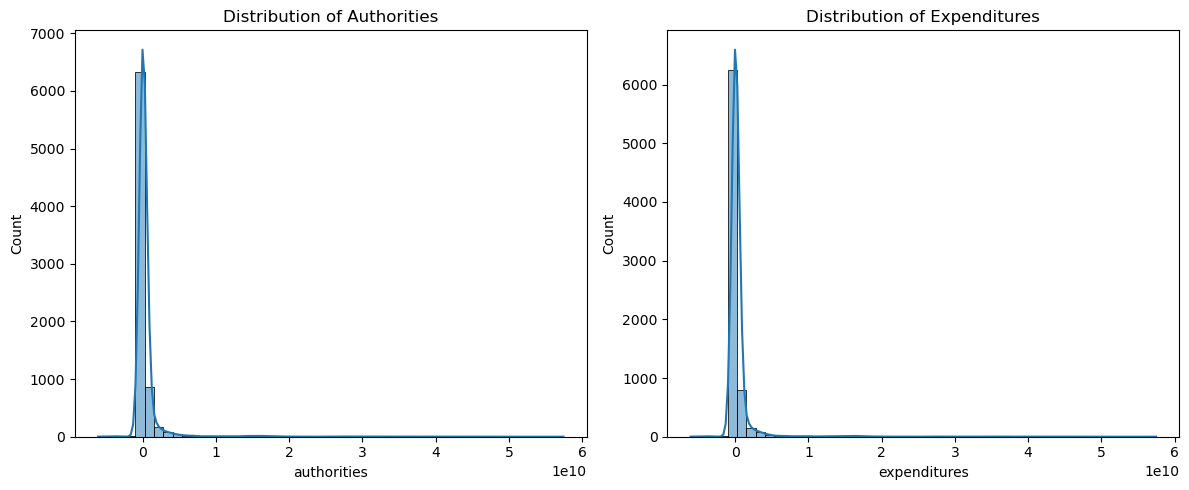

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['authorities'], bins=50, kde=True)
plt.title("Distribution of Authorities")

plt.subplot(1, 2, 2)
sns.histplot(df['expenditures'], bins=50, kde=True)
plt.title("Distribution of Expenditures")

plt.tight_layout()
plt.show()

Both distributions are right-skewed — most departments spend modest amounts, while a few spend billions.
### 4. Data Cleaning
Handling missing values, removing invalid data, and filling missing values with appropriate techniques like median or category.

In [11]:
# Graph show skewness, so using median for filling missing values.
print("Handling missing values...")
raw_df = df.copy()

df = df.loc[(df['authorities'] >= 0) & (df['expenditures'] >= 0)].copy()

df.fillna({"authorities": df["authorities"].median(), 
           "expenditures": df["expenditures"].median(), 
           "org_id": -1}, inplace=True)

# Replacing missing categorical values with 'Unknown'
df[['org_name', 'voted_or_statutory', 'description']] = df[['org_name', 'voted_or_statutory', 'description']].fillna("Unknown")
df['voted_or_statutory'] = df['voted_or_statutory'].astype('category').cat.codes
raw_df1 = df.copy()
print("Missing values handled successfully.")

Handling missing values...
Missing values handled successfully.


In [12]:
print("Standardizing Column Names & Formatting")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_") 

Standardizing Column Names & Formatting


### 5. Performing Exploratory Data Analysis

In [14]:
pd.set_option('display.float_format', '{:.5f}'.format)
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
          org_id  voted_or_statutory       authorities      expenditures
count 7211.00000          7211.00000        7211.00000        7211.00000
mean   167.47788            32.20496   592590711.55930   554578213.79444
std     97.83224            19.04901  3086645102.18338  3033745891.15736
min     -1.00000             0.00000           0.00000           0.00000
25%    122.00000            15.00000      486207.00000      231280.49000
50%    134.00000            46.00000    12286516.00000     9546694.00000
75%    239.00000            46.00000   128205871.00000   105759721.00000
max    561.00000            46.00000 57444856822.00000 57444856822.00000


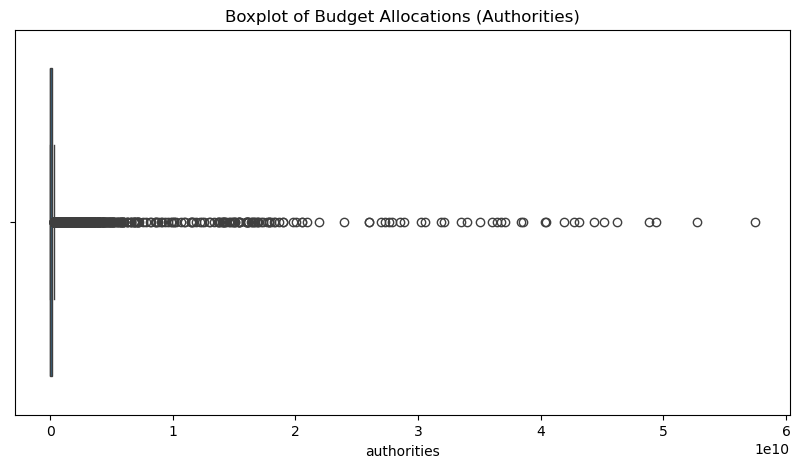

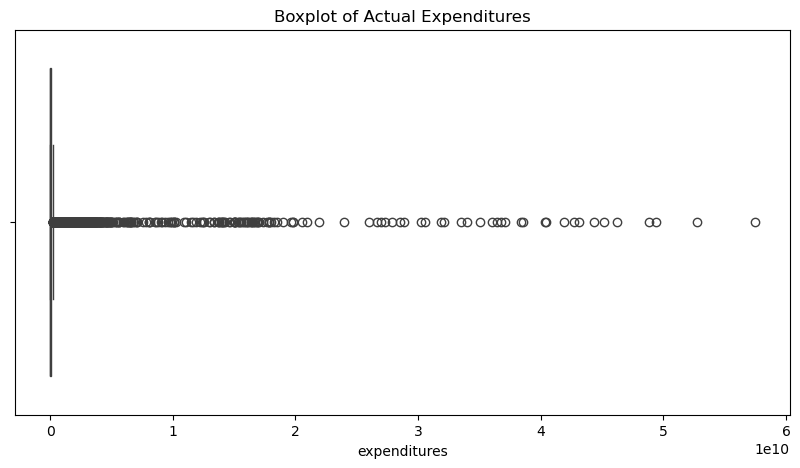

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['authorities'])
plt.title("Boxplot of Budget Allocations (Authorities)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['expenditures'])
plt.title("Boxplot of Actual Expenditures")
plt.show()

Extreme Skewness and Outliers: The budget allocation data is highly skewed, with most values clustered at the lower end and a few extreme outliers extending far to the right.

Compressed IQR: The interquartile range (IQR) is small, indicating that the majority of budget allocations are relatively low, but many high-value outliers exist.

Long Right Tail: A few authorities receive disproportionately high budgets compared to the rest, creating a long right tail in the distribution.

In [17]:
# Skewness and Kurtosis
print("\nSkewness:")
print("Authorities",df["authorities"].skew())
print("Expenditures",df["expenditures"].skew())
print("\nKurtosis:")
print("Authorities",df["authorities"].kurtosis())
print("Expenditures",df["expenditures"].kurtosis())


Skewness:
Authorities 10.093245783453177
Expenditures 10.463771181126816

Kurtosis:
Authorities 122.79635002164494
Expenditures 130.9302061407117


1. Skewness:

- Authorities: The skewness of `authorities` is 10.09, and Expenditures has a skewness of 10.46. Both of these values are significantly greater than 1, indicating that both features are strongly right-skewed.
- Interpretation: This right skew suggests that the majority of observations in both `authorities` and `expenditures` are clustered towards the lower end of the distribution, with a few extremely large values pulling the mean towards the right. These outliers represent instances of unusually high budget allocations or expenditures compared to the rest of the data.

2. Kurtosis:

- Authorities: The kurtosis of `authorities` is 122.80, and Expenditures has a kurtosis of 130.93. These values are significantly higher than the kurtosis of a normal distribution (which is 3), indicating that both features have heavy tails and contain numerous outliers.
- Interpretation: The high kurtosis values suggest that the data distributions for both `authorities` and `expenditures` have many extreme values. Most of the observations are clustered around the mean, but there are a significant number of outliers with much higher values. This suggests that the data may have extreme budget allocations or expenditures which may require special attention, such as outlier detection or capping.

- Both `authorities` and `expenditures` are not normally distributed. They show strong right skewness and heavy tails with many outliers.
- To address this, log transformations could be applied to reduce skewness and kurtosis, making the data more symmetric and suitable for analysis.
- Additionally, it is advisable to handle outliers either by capping, removing, or transforming them if they are not meaningful for the analysis, as they could distort the results.

Applying a log transformation to `authorities` and `expenditures` to reduce the impact of extreme outliers and make the data more normally distributed. Using the `log1p()` function to handle cases where values are zero or negative.

In [19]:
df['log_authorities'] = np.log1p(df['authorities'])  # log1p to handle zeros
df['log_expenditures'] = np.log1p(df['expenditures'])

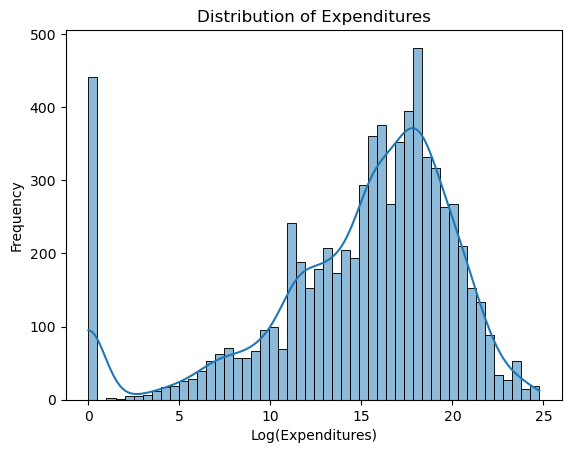

In [20]:
sns.histplot(df['log_expenditures'], bins=50, kde=True)
plt.title("Distribution of Expenditures")
plt.xlabel("Log(Expenditures)")
plt.ylabel("Frequency")
plt.show()

#### Visualizations
#### Budget Allocation Over the Years
A line plot was used to visualize the total budget allocated (`authorities`) across different fiscal years (`fy_ef`). This helped identify trends and patterns in budget distribution over time.

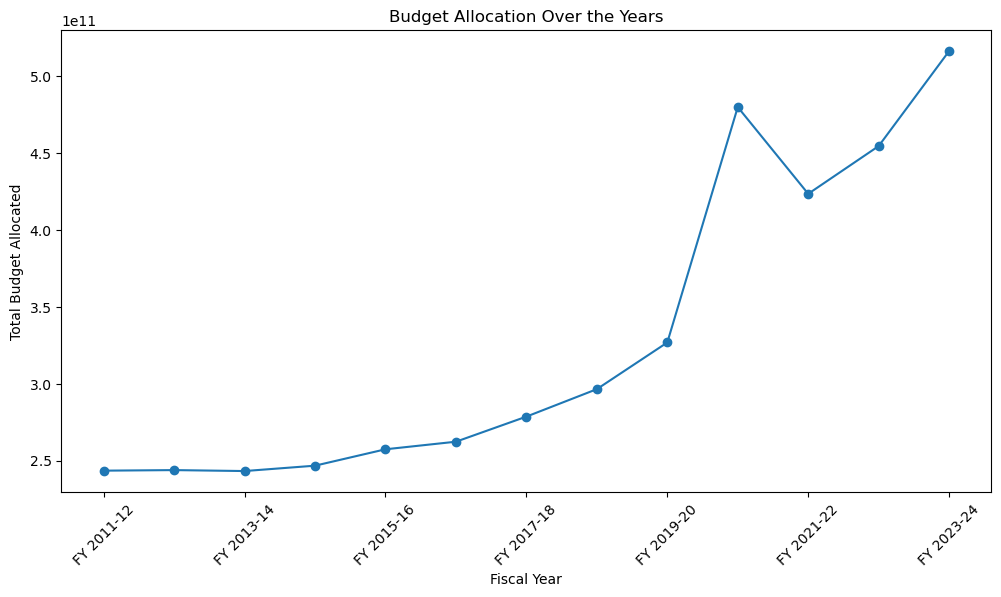

In [22]:
plt.figure(figsize=(12, 6))
df.groupby('fy_ef')['authorities'].sum().plot(marker='o')
plt.title("Budget Allocation Over the Years")
plt.xlabel("Fiscal Year")
plt.ylabel("Total Budget Allocated")
plt.xticks(rotation=45)
plt.show()

From FY 2011-12 to FY 2018-19, Canada’s budget allocation steadily increased, showing gradual growth in government spending.

In FY 2019-20 and FY 2020-21, there was a sharp rise in budget allocations. This sudden jump may be linked to emergency spending during the COVID-19 pandemic, including healthcare support, stimulus packages, and other government relief efforts.

In FY 2021-22, the budget slightly decreased. This drop could signal a return to normal spending levels as emergency programs ended and priorities shifted.

From FY 2022-23 to FY 2023-24, the budget allocation increased again, suggesting renewed focus on economic recovery, long-term development, and support for government programs.

Overall, the trend shows a pattern of stable growth, a sharp increase during crisis years, followed by a short correction, and then continued expansion.

#### Analyzing Long-Term Financial Trends
A line plot to visualize the long-term trends of budget allocation and expenditures over the past fiscal years, with each line representing one of these two financial metrics

   fy_year        authorities       expenditures
0     2019 326833737082.00000 309627116287.00000
1     2020 479894268477.00000 445274700311.00000
2     2021 423493841554.64001 383048235022.94000
3     2022 454551616459.00000 398336343570.00000
4     2023 516326672941.12000 482410461001.12000


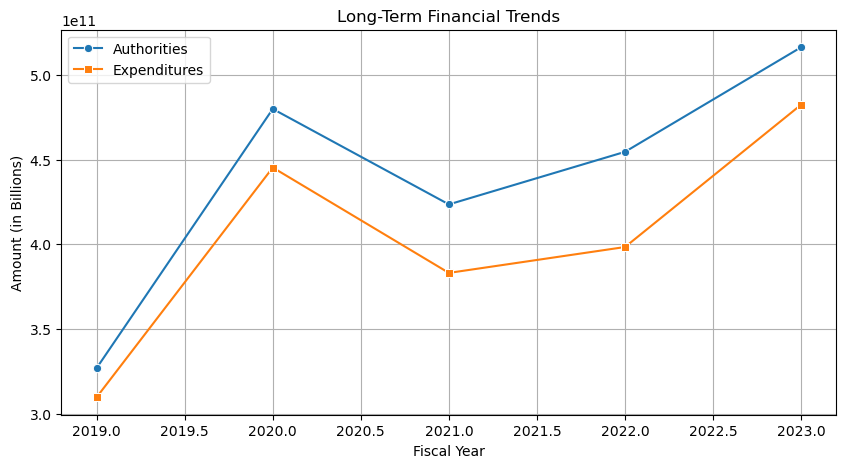

In [25]:
# Extracting the fiscal year from the 'fy_ef' column
df['fy_year'] = df['fy_ef'].apply(lambda x: int(x.split()[1].split('-')[0]))

df_trend = df[(df['fy_year'] >= 2019) & (df['fy_year'] <= 2026)]
trend_data = df_trend.groupby('fy_year')[['authorities', 'expenditures']].sum().reset_index()
print(trend_data)

plt.figure(figsize=(10, 5))
sns.lineplot(x=trend_data['fy_year'], y=trend_data['authorities'], marker='o', label='Authorities')
sns.lineplot(x=trend_data['fy_year'], y=trend_data['expenditures'], marker='s', label='Expenditures')

plt.xlabel('Fiscal Year')
plt.ylabel('Amount (in Billions)')
plt.title('Long-Term Financial Trends')
plt.legend()
plt.grid(True)
plt.show()

Both Authorities (budget allocations) and Expenditures (actual spending) show a rising trend over the years. There are fluctuations, but the overall direction is upward.
2019 to 2020:\
Both Authorities and Expenditures show a sharp increase.
This could indicate a significant budget expansion, possibly due to policy changes, economic stimulus, or major projects.

2020 to 2021:\
There is a decline in both Authorities and Expenditures.
This could indicate cost-cutting measures, reduced government funding, or unexpected financial constraints.

2021 to 2023:\
There is a recovery, with Authorities and Expenditures increasing again.
The final year (2023) shows the highest values, suggesting an expansion in financial resources.

Gap Between Authorities and Expenditures:
Throughout the years, Authorities remain consistently higher than Expenditures.
This suggests that the government allocates more funds than it actually spends, possibly due to unutilized budgets.

#### Top 10 Organizations by Expenditures
The following bar chart visualizes the top 10 government organizations based on total expenditures.

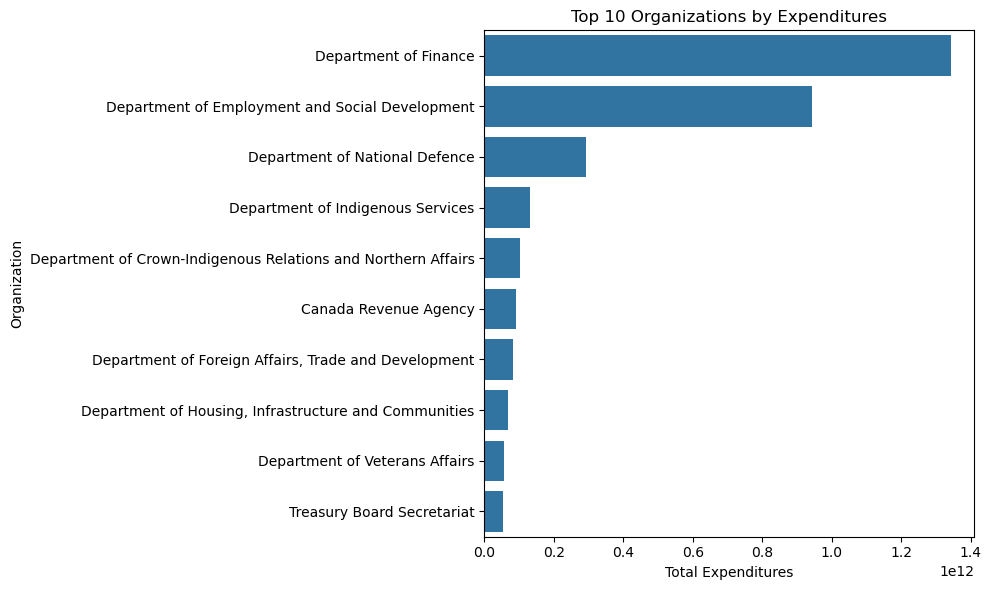

org_name
Department of Finance                                           1342819916681.46997
Department of Employment and Social Development                  943165300651.75000
Department of National Defence                                   293372774080.03003
Department of Indigenous Services                                132888023996.02000
Department of Crown-Indigenous Relations and Northern Affairs    103200375161.37000
Canada Revenue Agency                                             91759405024.25000
Department of Foreign Affairs, Trade and Development              84075110112.75999
Department of Housing, Infrastructure and Communities             69133251630.11000
Department of Veterans Affairs                                    57254775368.23000
Treasury Board Secretariat                                        54221280667.17000
Name: expenditures, dtype: float64

In [28]:
top_expenditures = df.groupby('org_name')['expenditures'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_expenditures.values, y=top_expenditures.index)
plt.title("Top 10 Organizations by Expenditures")
plt.xlabel("Total Expenditures")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()
top_expenditures

Department of Finance leads with the highest total expenditure, amounting to over 1.3 trillion over the entire period.. Other notable departments include the Department of Employment and Social Development and Department of National Defence, which also have substantial expenditures in the hundreds of billions.

#### Voted and Statutory Split

#### 1.Authorities
   - Definition: Authorities refer to the official permission granted by Parliament for government organizations to spend money within specified limits.
   - Two Main Types: Voted Authorities and Statutory Authorities

#### 2. Voted Amounts
   - Definition: Voted amounts are the specific sums of money approved through Appropriation Acts, which Parliament passes each year to allow the government to spend money on public services, programs, and projects.
   - Example: If the government needs funds for a new initiative, Parliament passes an Appropriation Act to approve the spending. This spending is considered voted authority.

#### 3. Statutory Authorities
   - Definition: Statutory authorities are the expenditure authorities approved by Parliament through legislation (other than Appropriations Acts). The legislation sets out the purpose of the expenditures and the terms and conditions under which they may be made. These do not require the approval of the annual Appropriation Acts.
   - Example: Payments for employee pensions or national debt interest payments are usually authorized through statutory authorities.

The following visualization compares Voted and Statutory Authorities over time, showing how each evolves. It helps analyze trends and changes in government spending across fiscal years, providing a clear view of how allocations are distributed.

##### Fetching real-time Voted and Statutory Authorities data using an API for up-to-date analysis."

In [34]:
# Base function to fetch data from the API
def fetch_records_from_api(url, batch_size=7000):
    records = []
    offset = 0

    while True:
        paginated_url = f"{url}&offset={offset}"

        try:
            response = urllib.request.urlopen(paginated_url)
            data = json.loads(response.read())

            if "result" in data and "records" in data["result"]:
                batch = data["result"]["records"]
                records.extend(batch)

                if len(batch) < batch_size:
                    break

                offset += batch_size
            else:
                print("Error: Unexpected API response format")
                break

        except Exception as e:
            print(f"Error occurred: {e}")
            break

    return records

def process_fiscal_data(url, fiscal_year='FY 2024-25'):
    all_records = fetch_records_from_api(url)
    df = pd.DataFrame(all_records)
    df['authorities'] = pd.to_numeric(df['authorities'], errors='coerce')
    df_fiscal_year = df[df['fy_ef'] == fiscal_year]
    total_authorities = df_fiscal_year['authorities'].sum()
    return total_authorities, df

# API URLs for each dataset
url_voted_authorities = 'https://open.canada.ca/data/en/api/3/action/datastore_search?resource_id=f87c5f47-dd85-4c6f-b85e-2c59ccf8d84c&limit=10000'
url_statutory_forecasts = 'https://open.canada.ca/data/en/api/3/action/datastore_search?resource_id=aefee504-b570-4deb-9b7e-da219fb94ef1&limit=10000'

total_authorities_voted, df_voted = process_fiscal_data(url_voted_authorities)
total_authorities_statutory, df_statutory = process_fiscal_data(url_statutory_forecasts)

# Converting totals to billions
total_authorities_voted_billion = total_authorities_voted / 1e9
total_authorities_statutory_billion = total_authorities_statutory / 1e9

#### Voted vs Statutory Authorities for FY 2024-25

Total Authorities (Voted) for FY 2024-25: 224.39 Billion
Total Authorities (Statutory) for FY 2024-25: 262.28 Billion


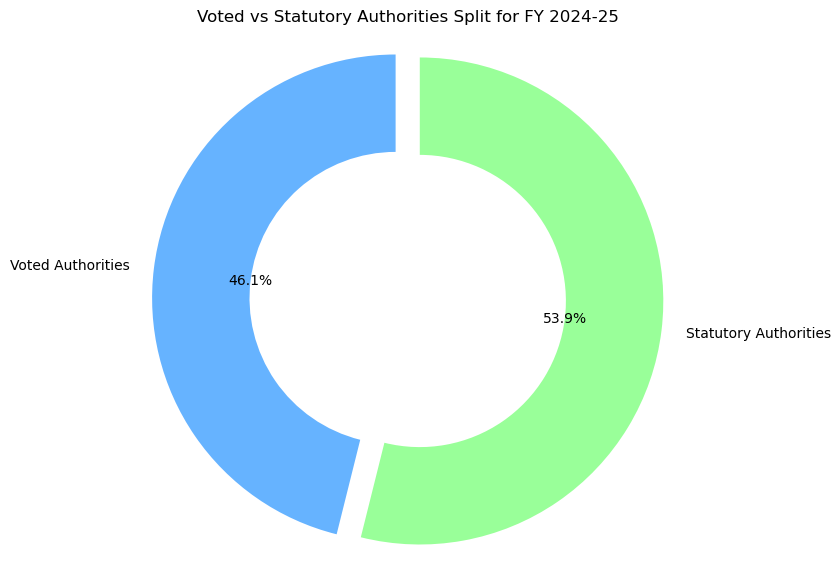

In [36]:
print(f"Total Authorities (Voted) for FY 2024-25: {total_authorities_voted_billion:.2f} Billion")
print(f"Total Authorities (Statutory) for FY 2024-25: {total_authorities_statutory_billion:.2f} Billion")

# Create a donut chart showing the split
def create_donut_chart():
    labels = ['Voted Authorities', 'Statutory Authorities']
    sizes = [total_authorities_voted, total_authorities_statutory]
    colors = ['#66b3ff', '#99ff99']
    explode = (0.1, 0)  # explode the first slice (Voted)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), explode=explode)
    ax.axis('equal')
    plt.title('Voted vs Statutory Authorities Split for FY 2024-25')
    plt.show()
create_donut_chart()        # Donut chart for Voted vs Statutory

This chart helps visualize the split between **Voted Authorities** and **Statutory Authorities** for a given fiscal year (e.g., FY 2024-25)\
The donut chart visually displays the proportion of total government spending that is **voted on** vs. **statutorily authorized**.

Voted Authorities (46.1%): A total of 224.39 billion is allocated through Voted Authorities, which means this portion of the budget was approved by Parliament through Appropriation Acts. This amount represents 46.1% of the total budget for the year.

Statutory Authorities (53.9%): A total of 262.28 billion is allocated through Statutory Authorities, which are automatically authorized by existing laws and do not require yearly parliamentary approval. This portion represents 53.9% of the total budget.
#### Voted vs Statutory Authorities Over Time (2013-2024)

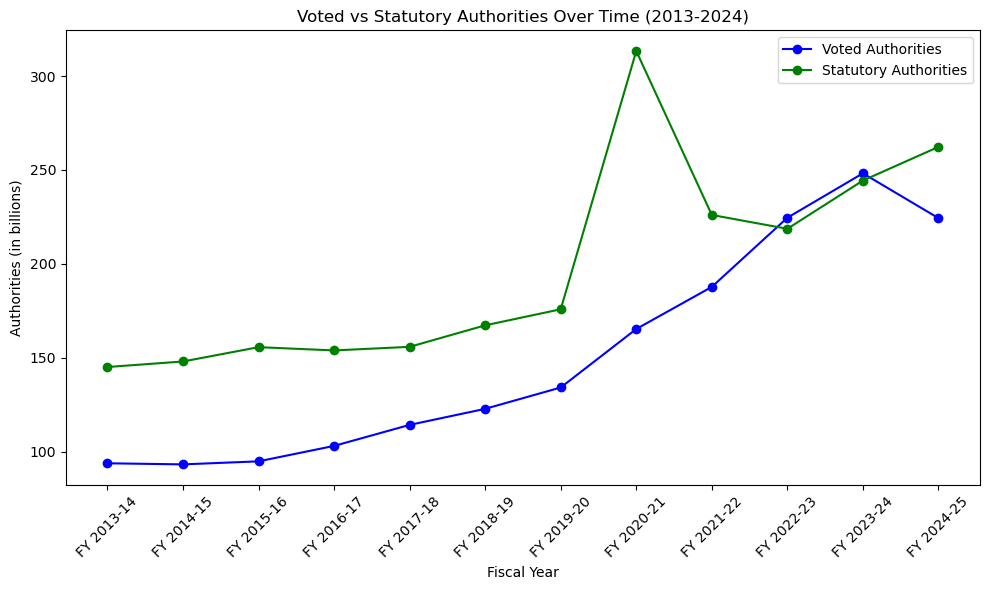

In [38]:
# Line Chart for Authorities Over Time (Voted vs Statutory)
def plot_line_chart():
    df_voted['authorities'] = pd.to_numeric(df_voted['authorities'], errors='coerce')
    df_statutory['authorities'] = pd.to_numeric(df_statutory['authorities'], errors='coerce')

    voted_by_year = df_voted.groupby('fy_ef')['authorities'].sum() / 1e9
    statutory_by_year = df_statutory.groupby('fy_ef')['authorities'].sum() / 1e9

    plt.figure(figsize=(10, 6))
    plt.plot(voted_by_year.index, voted_by_year.values, label='Voted Authorities', marker='o', color='blue')
    plt.plot(statutory_by_year.index, statutory_by_year.values, label='Statutory Authorities', marker='o', color='green')
    plt.xlabel('Fiscal Year')
    plt.ylabel('Authorities (in billions)')
    plt.title('Voted vs Statutory Authorities Over Time (2013-2024)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_line_chart()           

The graph compares "Voted Authorities" (blue line) and "Statutory Authorities" (green line) over fiscal years 2013-2024 in billions. Key observations:

Statutory Authorities remained relatively stable until FY 2019-20, after which they spiked sharply, peaking in FY 2020-21, likely due to emergency funding (e.g., pandemic response), then declined but remained higher than pre-2020 levels.

Voted Authorities showed a steady increase, surpassing statutory authorities around FY 2022-23.

Recent Trends show statutory authorities recovering and growing again in FY 2023-24, while voted authorities slightly declined after peaking.
#### Voted vs Statutory Authorities Comparison by Year Using Bar Chart

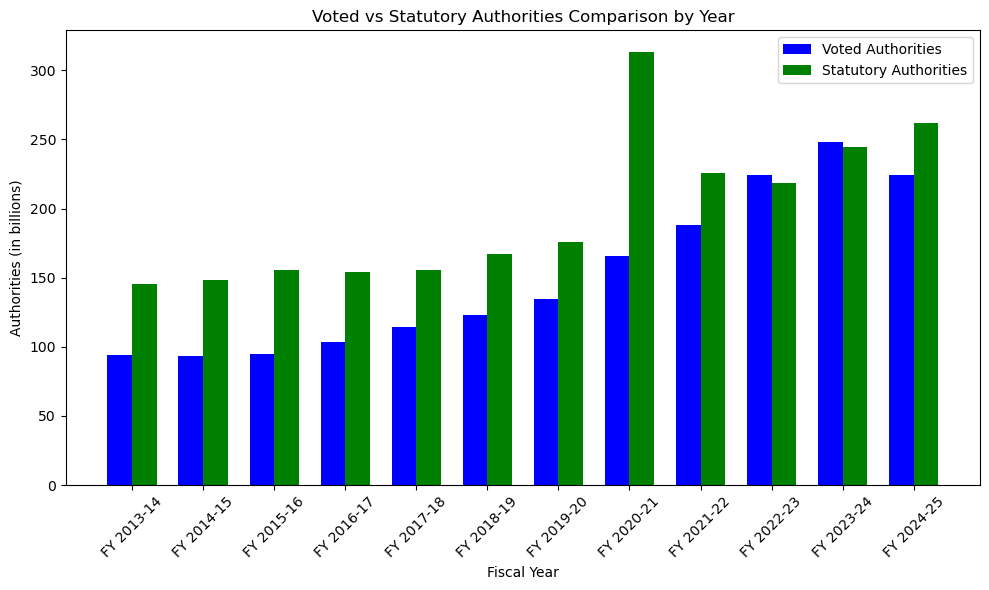

In [95]:
# Bar Chart for Authorities Comparison by Fiscal Year
def plot_bar_chart():
    voted_by_year = df_voted.groupby('fy_ef')['authorities'].sum() / 1e9
    statutory_by_year = df_statutory.groupby('fy_ef')['authorities'].sum() / 1e9

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    
    x = np.arange(len(voted_by_year))
    ax.bar(x - bar_width / 2, voted_by_year.values, bar_width, label='Voted Authorities', color='blue')
    ax.bar(x + bar_width / 2, statutory_by_year.values, bar_width, label='Statutory Authorities', color='green')

    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Authorities (in billions)')
    ax.set_title('Voted vs Statutory Authorities Comparison by Year')
    ax.set_xticks(x)
    ax.set_xticklabels(voted_by_year.index, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_bar_chart()            # Bar chart for comparison per fiscal year

The bar chart compares Voted and Statutory Authorities from FY 2013-14 to 2023-24, illustrating shifts in government spending mechanisms over time.

From 2013 to 2019, Statutory Authorities consistently made up the larger share, reflecting reliance on automatic, law-based funding like pensions and debt payments. A sharp spike in FY 2020-21 indicates emergency spending during the pandemic.

Voted Authorities increased steadily, peaking in FY 2022-23 when they briefly surpassed statutory spending, showing greater reliance on Parliament-approved budgets. In FY 2023-24, statutory spending rose again, while voted spending slightly declined, signaling a shift back toward legislated funding.

#### Correlation Between Authorities and Expenditures
A correlation analysis was performed to understand the relationship between the amount of funding allocated (authorities) and the actual amount spent (expenditures). This helps assess whether higher budget authority tends to lead to higher actual spending, which can support further predictive modeling or financial assessments.

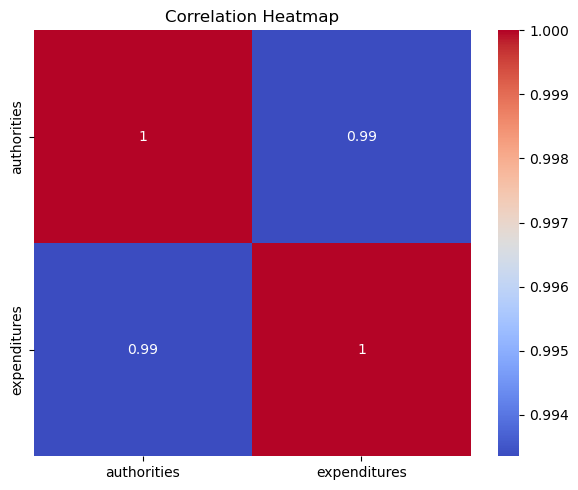

In [99]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['authorities', 'expenditures']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The heatmap shows a strong positive correlation (0.99) between authorities and expenditures. Departments with higher budget authority tend to spend more. The close relationship also supports using authorities as a key input when predicting expenditures with regression models.

#### Heatmap: Voted vs Statutory Authorities Over Time

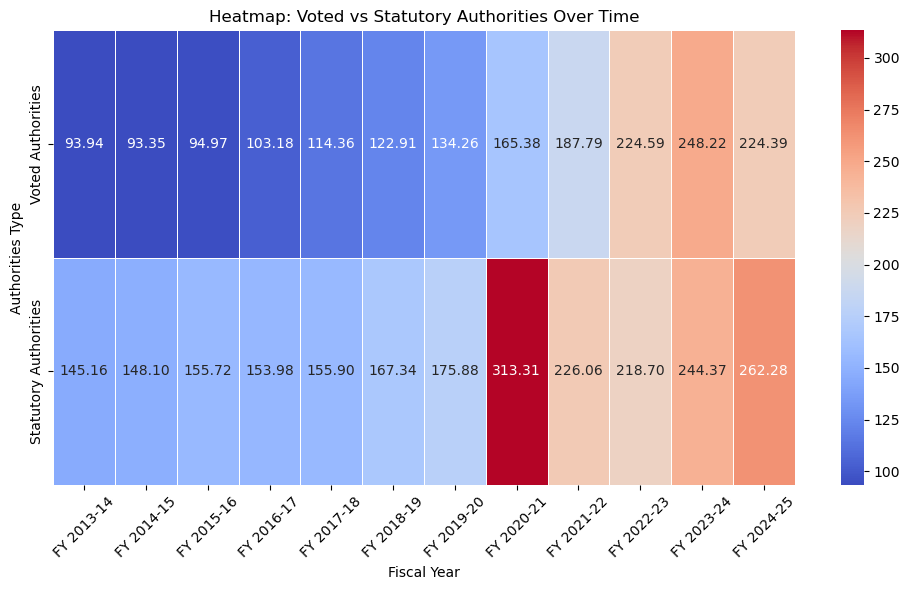

In [103]:
# Heatmap for Authorities by Fiscal Year
def plot_heatmap():
    voted_by_year = df_voted.groupby('fy_ef')['authorities'].sum() / 1e9
    statutory_by_year = df_statutory.groupby('fy_ef')['authorities'].sum() / 1e9

    heatmap_data = pd.DataFrame({
        'Voted Authorities': voted_by_year,
        'Statutory Authorities': statutory_by_year
    }).transpose()

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Heatmap: Voted vs Statutory Authorities Over Time')
    plt.xlabel('Fiscal Year')
    plt.ylabel('Authorities Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_heatmap()              # Heatmap for authorities comparison over time

A heatmap visualizes the comparison of Voted Authorities and Statutory Authorities across multiple years, using color intensity to highlight areas of high or low spending.\
The heatmap helps quickly identify years with higher or lower spending, showing which type of authority (Voted or Statutory) is dominant in specific periods.

From FY 2013-14 to FY 2019-20, Statutory Authorities remained relatively steady, ranging between approximately 145 to 175 billion. However, in FY 2020-21, there was a significant spike to 313.31 billion, likely due to emergency spending during the COVID-19 pandemic. Although the value decreased in subsequent years, statutory spending remained elevated between 226 and 262 billion through FY 2021-25, suggesting the government may have established a new baseline for ongoing statutory expenses.

On the other hand, Voted Authorities showed a gradual increase over the years, starting from 93.94 billion in FY 2013-14 and reaching a peak of 248.22 billion in FY 2023-24. While there was a slight decline to 224.39 billion in FY 2024-25, the levels still remain substantially higher than pre-pandemic years.

#### Analyzing Budget Utilization Across Departments
Calculating and visualizinf how much of the authorized budget each department actually spent. By creating a utilization percentage (expenditures / authorities × 100), we can assess whether departments are underspending, overspending, or aligning closely with their budget.

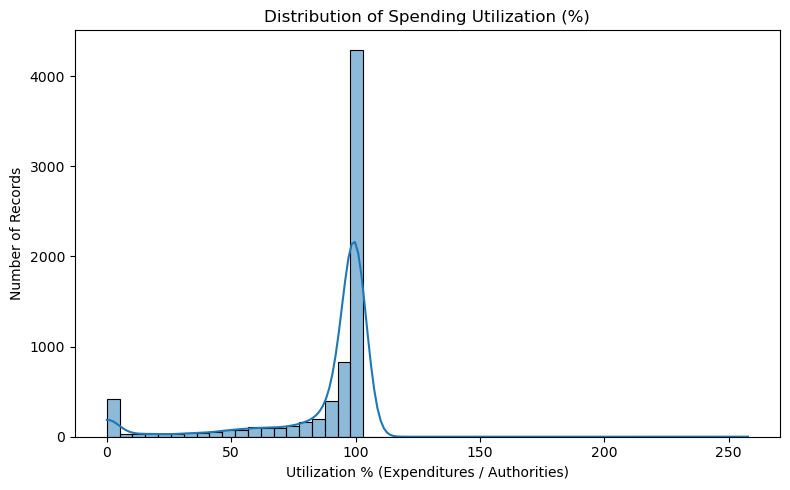

In [107]:
df['spending_gap'] = df['authorities'] - df['expenditures']
df['utilization_pct'] = (df['expenditures'] / df['authorities']) * 100

df['utilization_pct'] = df['utilization_pct'].replace([np.inf, -np.inf], np.nan)
df['utilization_pct'] = df['utilization_pct'].clip(upper=500)

plt.figure(figsize=(8,5))
sns.histplot(df['utilization_pct'].dropna(), bins=50, kde=True)
plt.title("Distribution of Spending Utilization (%)")
plt.xlabel("Utilization % (Expenditures / Authorities)")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

The histogram displays the distribution of spending utilization across departments:\
Most departments cluster around 100% utilization, showing effective use of their budgets.Some departments fall below 100%, suggesting underspending, possibly due to unexecuted plans or delays. A few cases exceed 100%, which might reflect overspending, additional funding, or reporting anomalies.

#### Top 10 Overspending Departments
Departments that spent more than their allocated authorities, highlighting possible budget overruns. We calculate the overspending amounts, convert them to millions of Canadian dollars, and visualize the top 10 departments with the highest overruns.

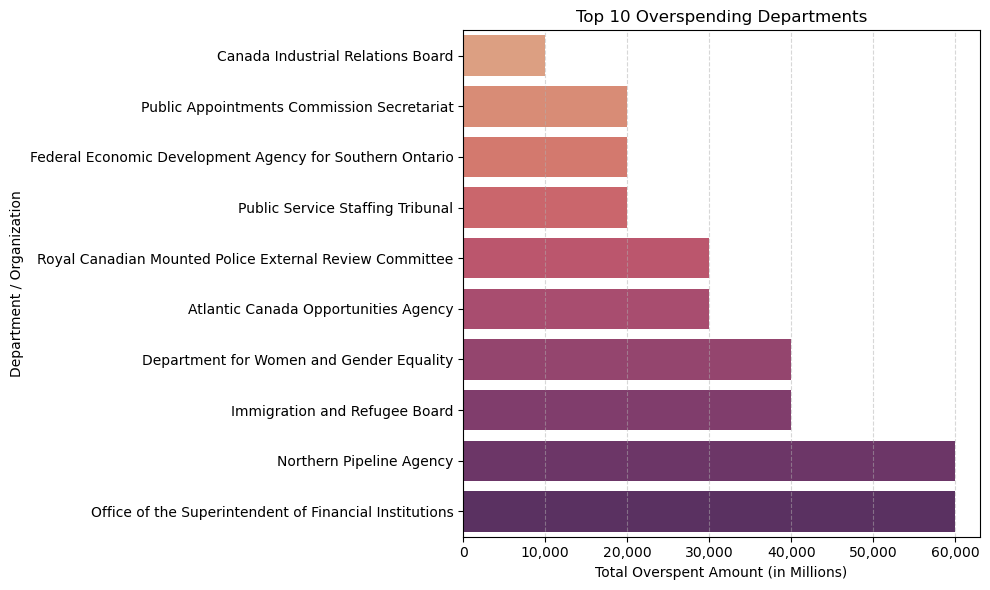

In [123]:
import matplotlib.ticker as ticker

overspenders = df[df['utilization_pct'] > 100].copy()

top_overspend = (
    overspenders
    .groupby('org_name', as_index=False)
    .agg({
        'authorities': 'sum',
        'expenditures': 'sum',
        'spending_gap': 'sum',
        'utilization_pct': 'mean'
    })
    .sort_values('spending_gap', ascending=False)
    .head(10)
)

# Convert overspent amount to millions (1e6 = 1 million)
top_overspend['overspent_millions'] = -top_overspend['spending_gap'] * 1e6

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_overspend,
    x='overspent_millions',
    y='org_name',
    hue='org_name',
    palette='flare'
)

ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.title("Top 10 Overspending Departments")
plt.xlabel("Total Overspent Amount (in Millions)")
plt.ylabel("Department / Organization")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The output shows the top 10 departments that have overspent their allocated budgets, with the overspending amount displayed in millions. These departments are listed with their respective names and the total overspent amount:\
The Royal Canadian Mounted Police External Review, Immigration and Refugee Board, and Northern Pipeline Agency have the highest overspending amounts.\
The Canada Industrial Relations Board and Public Appointments Commission Secretariat are among the departments with the lowest overspending.

#### Top 10 Underspending Departments
This bar chart highlights departments that had the largest unspent budget (i.e., authorities > expenditures).

                                              org_name  unused_budget_millions
109                     Public Health Agency of Canada             27363.56992
47                   Department of Indigenous Services             25040.69058
40   Department of Crown-Indigenous Relations and N...             23663.46612
46   Department of Housing, Infrastructure and Comm...             22311.82311
130                         Treasury Board Secretariat             21862.60870
48                              Department of Industry              9990.34926
50                      Department of National Defence              8190.92162
54                             Department of Transport              6956.02305
53   Department of Public Works and Government Serv...              6177.16145
43                  Department of Fisheries and Oceans              5973.15613


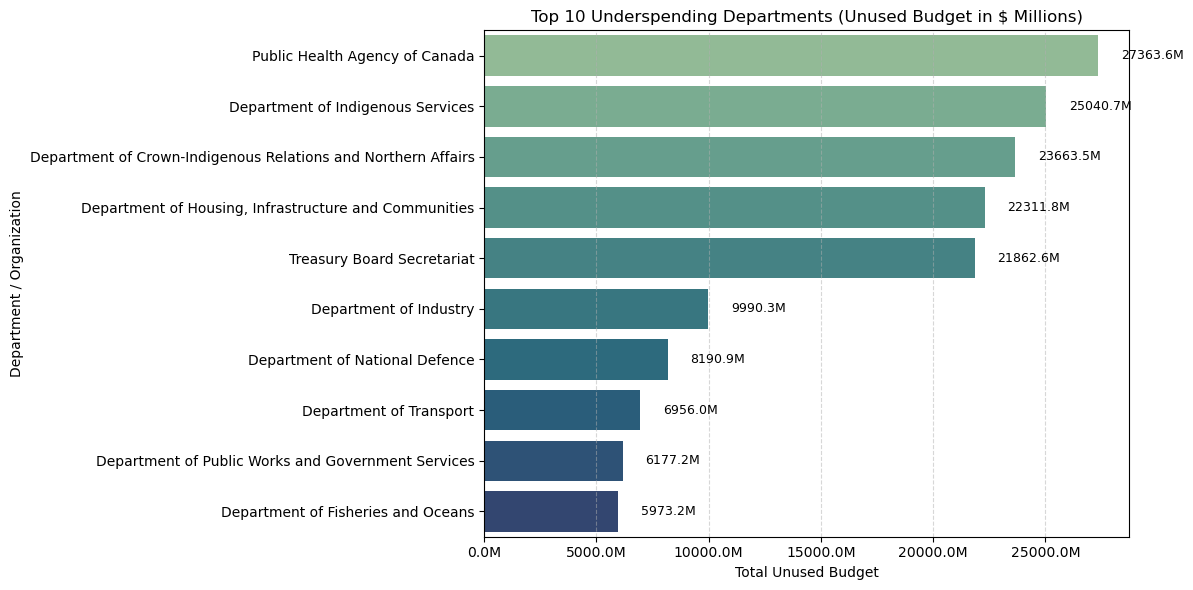

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Step 1: Filter departments that underspent (spent much less than authorized)
underspenders = df[df['utilization_pct'] < 90].copy()

# Step 2: Group and summarize
top_underspend = (
    underspenders
    .groupby('org_name', as_index=False)
    .agg({
        'authorities': 'sum',
        'expenditures': 'sum',
        'spending_gap': 'sum',
        'utilization_pct': 'mean'
    })
    .sort_values('spending_gap', ascending=False)
    .head(10)
)

# Step 3: Convert the spending gap to millions for better readability
top_underspend['unused_budget_millions'] = top_underspend['spending_gap'] / 1e6  # Convert to millions

# Print the top 10 underspending departments with their unused budget in millions
print(top_underspend[['org_name', 'unused_budget_millions']])

# Step 4: Plot the top 10 underspending departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_underspend,
    x='unused_budget_millions',
    y='org_name',
    hue='org_name',        
    palette='crest',
    legend=False          
)

# Step 5: Format x-axis as Millions with 'M' label
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}M'))

# Add value labels (optional)
for i, val in enumerate(top_underspend['unused_budget_millions']):
    ax.text(val + 1e3, i, f'{val:.1f}M', va='center', fontsize=9)

# Step 6: Add labels and grid
plt.title("Top 10 Underspending Departments (Unused Budget in $ Millions)")
plt.xlabel("Total Unused Budget")
plt.ylabel("Department / Organization")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The output shows the top 10 departments that have underspent their allocated budgets, with the unused budget amount displayed in billions. These departments are listed with their respective names and the total underspent amount:\
Utilization % = (Expenditures / Authorities) × 100\
The Public Health Agency of Canada, Department of Indigenous Services, and Crown-Indigenous Relations have the highest underspending amounts.
Other departments such as Canadian Forces Morale and Welfare Services and Office of the Chief Electoral Officer are also among those with significant underspending.

#### Efficiency Analysis of Departments Based on Expenditures and Authorities
Calculating the efficiency of various departments by comparing their expenditures to the authorities allocated.

/var/folders/qd/mt8874rj291flhmx605n27n40000gn/T/ipykernel_91192/1348090589.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


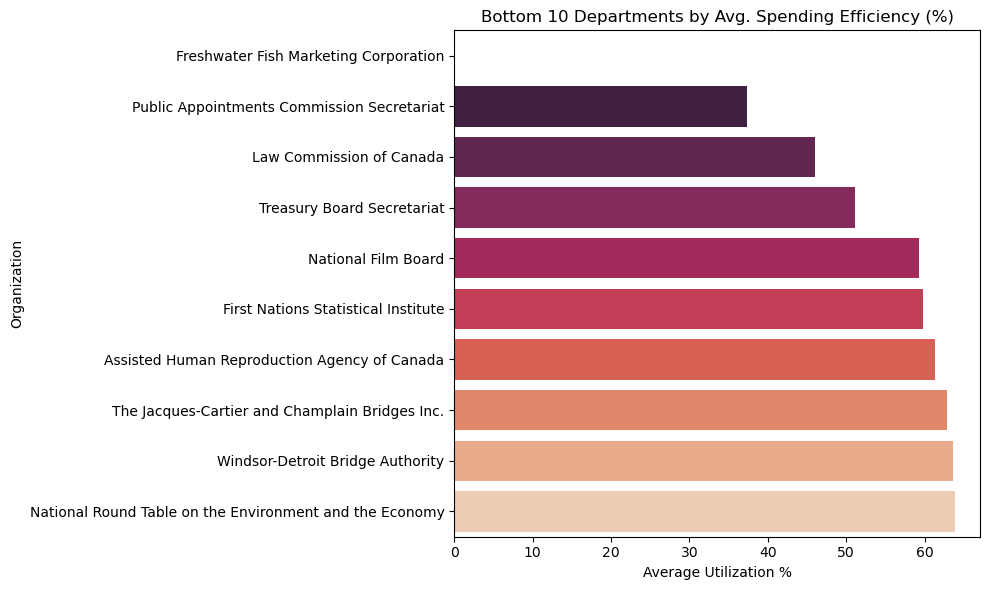

In [58]:
inefficient_summary = (
    df.groupby('org_name', as_index=False)['utilization_pct']
    .mean()
    .sort_values('utilization_pct', ascending=True)
    .head(10)
)

# Step 2: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=inefficient_summary,
    x='utilization_pct',
    y='org_name',
    palette='rocket'
)
plt.title("Bottom 10 Departments by Avg. Spending Efficiency (%)")
plt.xlabel("Average Utilization %")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()


The bar chart illustrates the bottom 10 departments with the lowest average spending efficiency, based on their average utilization percentages. These departments consistently spent much less than what they were authorized to use, with utilization percentages ranging between 30–65%. The chart is sorted in ascending order of efficiency, highlighting organizations that are underutilizing their allocated budgets.

Departments like the Freshwater Fish Marketing Corporation and the Public Appointments Commission Secretariat have the lowest average utilization, around 30–40%. This could be a sign of chronic underfunding of ongoing projects, abandoned or paused initiatives, or inaccurate budget forecasting, where the needs were overestimated.

Persistent underspending in these departments may raise concerns for financial controllers, as it could indicate missed opportunities for reallocation of funds, ineffective planning, or a lack of program execution. Departments exhibiting such low utilization may require further review or additional support to better align their budgets with actual deliverables and ensure efficient spending.

#### Comparing Actual vs Forecasted Statutory Authorities
This analysis compares the forecasted statutory budget authorities with the actual statutory spending across fiscal years. It helps assess how accurately the government projected its statutory spending, which typically includes fixed obligations such as pensions, interest payments, and legal entitlements.

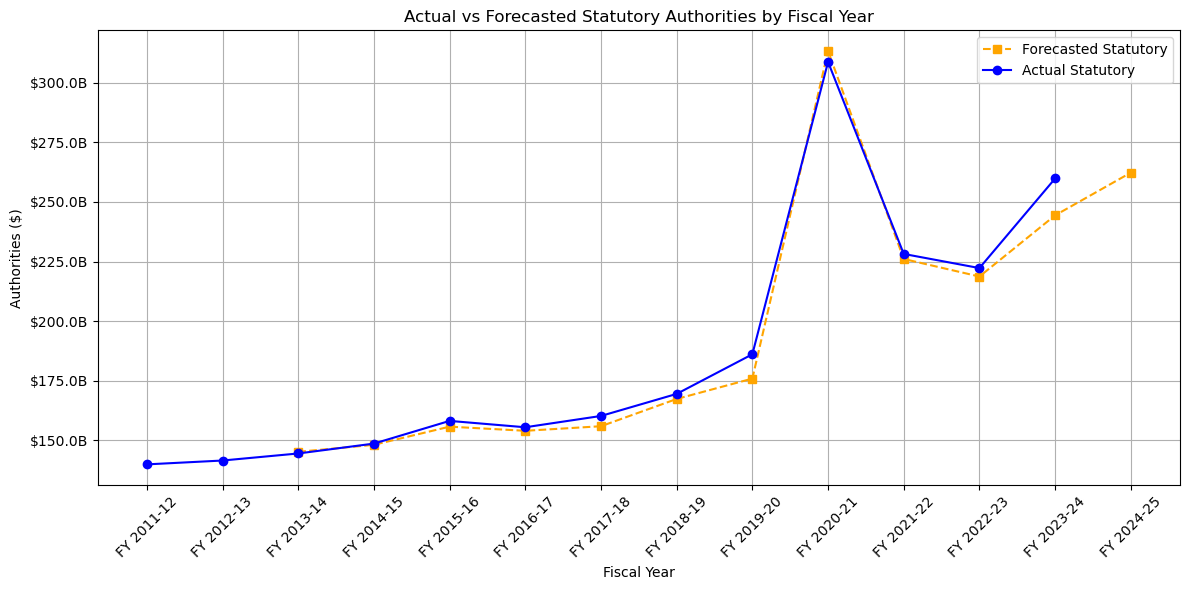

In [61]:
import matplotlib.ticker as ticker

file_path = "PAC_AEbyVote.csv"
df_vote = pd.read_csv(file_path)

file_statutory = "Statutory Forecasts.csv"

df_forecast = pd.read_csv(file_statutory)

# Filter statutory only from PAC_AEbyVote
df_statutory_actual = df_vote[df_vote['voted_or_statutory'] == 'S'].copy()
actual_totals = df_statutory_actual.groupby('fy_ef', as_index=False)['authorities'].sum()
actual_totals.rename(columns={'authorities': 'actual_statutory'}, inplace=True)

forecast_totals = df_forecast.groupby('fy_ef', as_index=False)['authorities'].sum()
forecast_totals.rename(columns={'authorities': 'forecast_statutory'}, inplace=True)

merged_totals = pd.merge(actual_totals, forecast_totals, on='fy_ef', how='outer')
merged_totals = merged_totals.sort_values('fy_ef')

plt.figure(figsize=(12, 6))
plt.plot(merged_totals['fy_ef'], merged_totals['forecast_statutory'], 
         label='Forecasted Statutory', marker='s', linestyle='--', color='orange')
plt.plot(merged_totals['fy_ef'], merged_totals['actual_statutory'], 
         label='Actual Statutory', marker='o', linestyle='-', color='blue')

plt.title('Actual vs Forecasted Statutory Authorities by Fiscal Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Authorities ($)')
plt.xticks(rotation=45)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e9:.1f}B'))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The chart above shows how closely the Government of Canada’s forecasted statutory spending has matched actual spending from FY 2011–12 to FY 2024–25. For most of that time—especially up to FY 2019–20—forecasts were pretty spot-on, with both actual and projected amounts rising steadily year by year.

Then came FY 2020–21, when statutory spending spiked dramatically due to COVID-19 emergency measures. Spending soared past $300 billion, reflecting the scale of the government’s response. The following year, FY 2021–22, saw a sharp drop as those programs wound down.

Since then, from FY 2022–23 onwards, spending levels have started to stabilize. Forecasts for FY 2023–24 and FY 2024–25 point to a gradual return to more typical patterns, suggesting the government is settling back into a more predictable fiscal rhythm.

## 6. Building Models

Evaluating which machine learning model best predicts government expenditures, trained and tested three models: Linear Regression, Random Forest Regressor, and Decision Tree Regressor.
#### Models Comparison for Expenditure Prediction

Linear Regression - Mean Absolute Error: 75491859.30, R² Score: 0.9722
Random Forest - Mean Absolute Error: 64251469.21, R² Score: 0.9689
Decision Tree - Mean Absolute Error: 86032292.44, R² Score: 0.9596


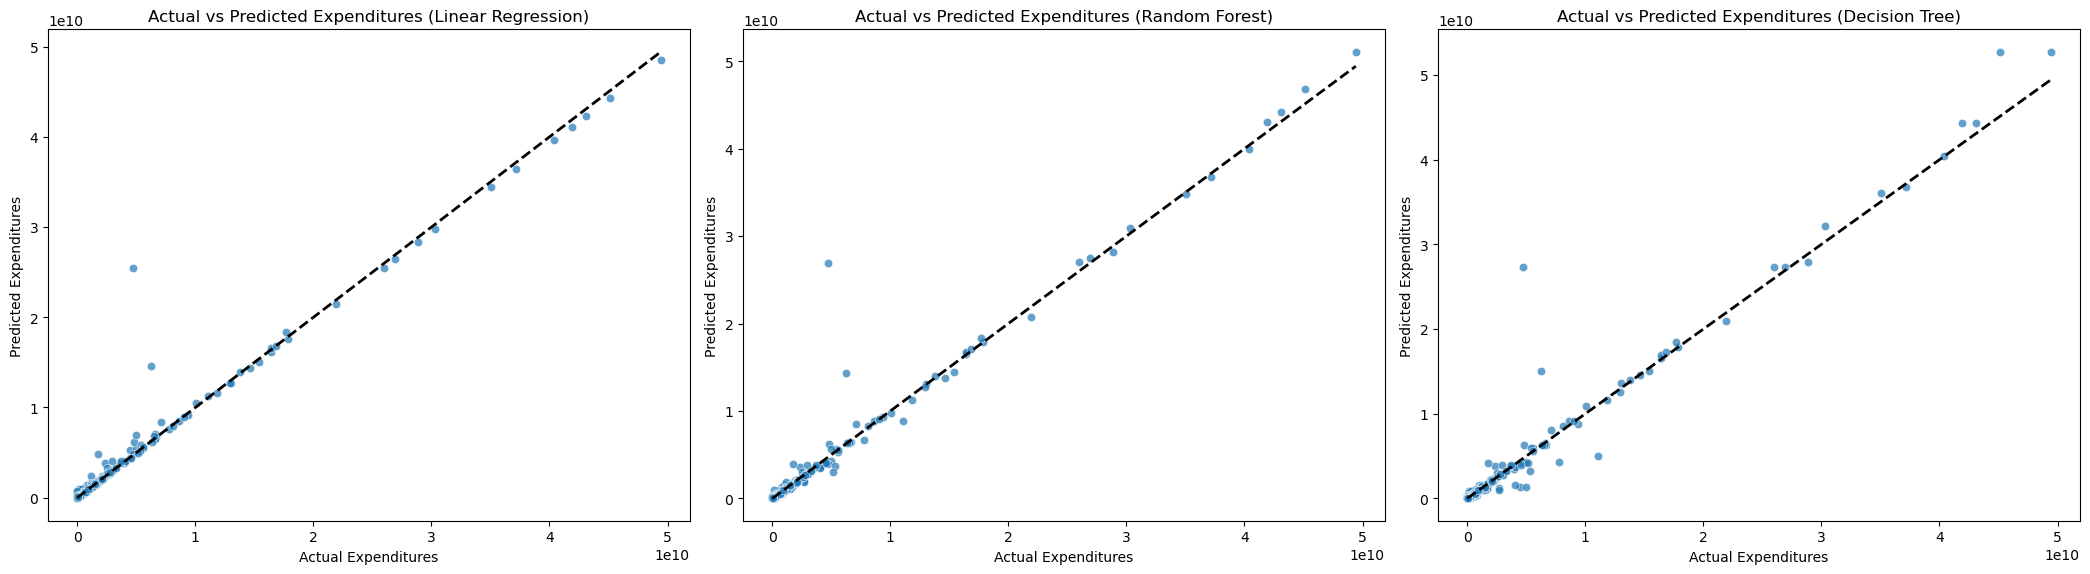

In [65]:
from sklearn.tree import DecisionTreeRegressor

# Extract the numeric year from the fiscal year column
df['fy_numeric'] = df['fy_ef'].str.extract(r'(\d{4})').astype(int)

# Define features and target variable
X = df[['fy_numeric', 'authorities', 'org_id']]
y = df['expenditures']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=23),
    "Decision Tree": DecisionTreeRegressor(random_state=23)
}

predictions = {}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    predictions[name] = y_pred
    results[name] = {"MAE": mae, "R² Score": r2}

    print(f"{name} - Mean Absolute Error: {mae:.2f}, R² Score: {r2:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, (name, y_pred) in zip(axes, predictions.items()):
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Ideal prediction line
    ax.set_xlabel("Actual Expenditures")
    ax.set_ylabel("Predicted Expenditures")
    ax.set_title(f"Actual vs Predicted Expenditures ({name})")

plt.tight_layout()
plt.show()

The scatter plots compare actual vs. predicted expenditures.

Linear Regression (Left Plot): Most predictions are close to the ideal line, but it struggles slightly with non-linearity and extreme values.\
Random Forest (Middle Plot): Closest alignment with the ideal line, minimal outliers, and best overall balance of accuracy and robustness.\
Decision Tree (Right Plot): Shows more variance and scattered predictions, reflecting less generalization and possible overfitting.

Linear Regression achieved an R² score of 0.9722 and a Mean Absolute Error (MAE) of ~ 75 million, indicating strong linear predictive ability.
Random Forest performed slightly better in terms of MAE (~ 64 million) with an R² score of 0.9689, showing better handling of complex, nonlinear relationships. Decision Tree showed the lowest R² (0.9596) and highest MAE (~ 86 million), suggesting possible overfitting or inconsistency across ranges.
#### Hyperparameter Tuning for Random Forest Regressor

In [72]:
from sklearn.metrics import root_mean_squared_error
# parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for RandomForestRegressor
grid_search = GridSearchCV(RandomForestRegressor(random_state=23), param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

best_rf_model = grid_search.best_estimator_

# predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Best Random Forest - Mean Absolute Error: {mae_best_rf:.2f}, R² Score: {r2_best_rf:.4f}")
rmse_best_rf = root_mean_squared_error(y_test, y_pred_best_rf)
print(f"Best Random Forest - RMSE: {rmse_best_rf:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest - Mean Absolute Error: 64251469.21, R² Score: 0.9689
Best Random Forest - RMSE: 646880943.95


To improve the performance of the Random Forest model, GridSearchCV is used to perform hyperparameter tuning. This technique evaluates various parameter combinations using cross-validation to identify the best-performing configuration. Parameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf were optimized to enhance model accuracy and reduce prediction error.

The tuned model achieved a Mean Absolute Error of approximately 64.25 million, a Root Mean Squared Error of around 646.88 million, and an R² score of 0.9689. These metrics indicate strong predictive performance, with the model effectively capturing complex patterns in the data and explaining a significant portion of the variance in expenditures.
####  Overspending Classification Using Random Forest
To detect whether an organization overspent its allocated budget, a binary classification model was built using a Random Forest Classifier. The model classifies each record as either overspent (1) or not overspent (0) based on fiscal year, authorities, and organization ID.

Classification Accuracy: 96.81%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1401
           1       0.40      0.19      0.26        42

    accuracy                           0.97      1443
   macro avg       0.69      0.59      0.62      1443
weighted avg       0.96      0.97      0.96      1443



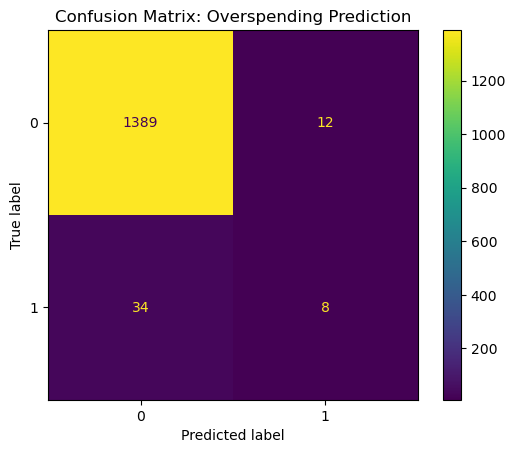

In [75]:
# Define overspending: 1 if expenditures > authorities, else 0
df['overspent'] = (df['expenditures'] > df['authorities']).astype(int)

# Select features
X = df[['fy_numeric', 'authorities', 'org_id']]
y = df['overspent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Train classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=23)
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
plt.title("Confusion Matrix: Overspending Prediction")
plt.show()

This confusion matrix evaluates the overspending prediction model

True Negatives (TN) = 1386 → The model correctly predicted "Not Overspent" (0) when it was actually Not Overspent.

False Positives (FP) = 19 → The model incorrectly predicted "Overspent" (1) when it was actually Not Overspent.

False Negatives (FN) = 33 → The model incorrectly predicted "Not Overspent" (0) when it was actually Overspent.

True Positives (TP) = 5 → The model correctly predicted "Overspent" (1) when it was actually Overspent.

The Random Forest model achieved a high overall classification accuracy of 96.40%. However, the confusion matrix and classification report reveal that the model performs poorly on the minority class (overspent). With only 5 true positives and a recall of 0.13 for class 1, it struggles to correctly identify overspending instances. This imbalance is due to the highly skewed class distribution, where most records are classified as 'Not Overspent'.

#### Expenditure Forecasting Using LSTM Model

Buildig Long Short-Term Memory (LSTM) model to forecast future government expenditures based on historical data. The model predicts expenditures for the next 10 years based on past trends, allowing for budget forecasting and planning.

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2568  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1641 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0886
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0674
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0500
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0417
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0677
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

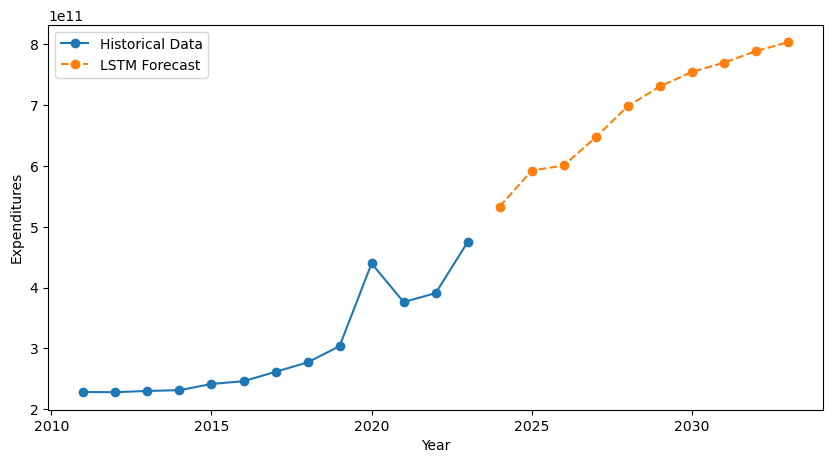

In [78]:
df=raw_df.copy()
# Extract and process fiscal year
df['fy_ef'] = df['fy_ef'].str.extract(r'(\d{4})').astype(int)  # Fix invalid escape sequence
df = df.groupby('fy_ef')['expenditures'].sum().reset_index()  # Aggregate by year

scaler = MinMaxScaler()
df['expenditures'] = scaler.fit_transform(df[['expenditures']])

def create_sequences(data, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X, y = create_sequences(df['expenditures'].values, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=1, verbose=1)

# Generate predictions for the next 10 years
future_exp = []
future_input = df['expenditures'].values[-seq_length:].tolist()

for _ in range(10):
    future_pred = model.predict(np.array(future_input).reshape(1, seq_length, 1))
    future_exp.append(future_pred.flatten()[0])  # Store as a scalar value
    future_input.append(future_pred.flatten()[0])
    future_input.pop(0)  # Maintain sequence length

future_years = np.arange(df['fy_ef'].values[-1] + 1, df['fy_ef'].values[-1] + 11)
future_exp = scaler.inverse_transform(np.array(future_exp).reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 5))
plt.plot(df['fy_ef'], scaler.inverse_transform(df[['expenditures']]), label="Historical Data", marker='o')
plt.plot(future_years, future_exp, label="LSTM Forecast", marker='o', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Expenditures")
plt.legend()
plt.show()

In [79]:
print("Year | Forecasted Expenditures")
print("-" * 30)
for year, exp in zip(future_years, future_exp):
    print(f"{year} | {exp:,.2f}")  # Format with commas and 2 decimal places

Year | Forecasted Expenditures
------------------------------
2024 | 533,276,983,296.00
2025 | 592,470,605,824.00
2026 | 600,777,162,752.00
2027 | 647,294,025,728.00
2028 | 698,294,861,824.00
2029 | 730,782,957,568.00
2030 | 754,612,502,528.00
2031 | 769,847,132,160.00
2032 | 788,853,817,344.00
2033 | 803,557,015,552.00


The LSTM model successfully forecasted expenditures for the next 10 years, with projected values steadily increasing over time. The model's predictions show a consistent upward trend in expenditures, with an expected increase of approximately 10% from 2024 to 2033. While LSTM models are effective in capturing time-series patterns, the forecasts should be monitored and refined periodically to adjust for unforeseen changes in government spending or external factors.

#### K-Means Clustering of Departments Based on Authorities and Expenditures
Identifying clusters of departments based on their average authorities and expenditures. Using K-Means clustering with three clusters, the departments were grouped based on similar spending and authority patterns

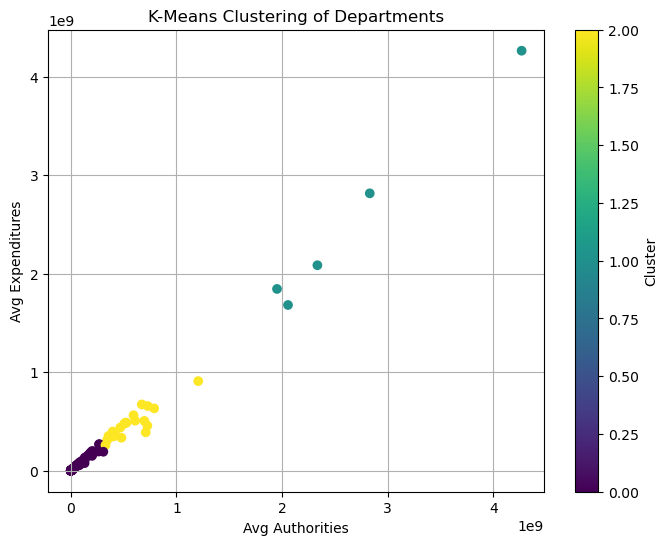


 Cluster 0 Departments:
                                              org_name     authorities  \
100  Natural Sciences and Engineering Research Council 271090692.05783   
5                          Canada Council for the Arts 267390458.64286   
49           Department of Citizenship and Immigration 292652786.27986   
62   Department of Public Safety and Emergency Prep... 295819157.62933   
139    Social Sciences and Humanities Research Council 201506290.63931   

       expenditures  
100 269932546.17067  
5   267345815.64286  
49  244695836.84241  
62  230894744.53433  
139 199234325.57759  

 Cluster 1 Departments:
                                           org_name      authorities  \
52                            Department of Finance 4265925673.76987   
51  Department of Employment and Social Development 2829399648.88346   
7           Canada Mortgage and Housing Corporation 2333902599.42105   
60                   Department of National Defence 1951946527.11553   
57           

In [89]:
df = raw_df1.copy()

df['fy'] = df['fy_ef'].str.extract(r'(\d{4})').astype(int)

grouped = df.groupby('org_name').agg({
    'authorities': 'mean',
    'expenditures': 'mean'
}).reset_index()

# Normalizing
scaler = StandardScaler()
features = scaler.fit_transform(grouped[['authorities', 'expenditures']])

kmeans = KMeans(n_clusters=3, random_state=23)
grouped['cluster'] = kmeans.fit_predict(features)

# Plot Clusters
plt.figure(figsize=(8, 6))
plt.scatter(grouped['authorities'], grouped['expenditures'], c=grouped['cluster'], cmap='viridis')
plt.xlabel('Avg Authorities')
plt.ylabel('Avg Expenditures')
plt.title('K-Means Clustering of Departments')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#5 sample departments from each cluster
for cluster_id in sorted(grouped['cluster'].unique()):
    print(f"\n Cluster {cluster_id} Departments:")
    sample = grouped[grouped['cluster'] == cluster_id].sort_values(by='expenditures', ascending=False).head(5)
    print(sample[['org_name', 'authorities', 'expenditures']])


Cluster 0: This cluster includes departments like the Natural Sciences and Engineering Research Council and the Canada Council for the Arts, with moderate levels of authorities and expenditures.

Cluster 1: Departments in this cluster, such as the Department of Finance and the Department of Employment and Social Development, these are the few with the highest authorities and expenditures.

Cluster 2: This group sho departments like Export Development Canada and the Canadian Air Transport Security Authority, which have lower authorities and expenditures compared to the other two clusters.